# Visualizing indicator data from the World Bank using python


<img src='https://cdn.pixabay.com/photo/2016/10/20/18/35/sunrise-1756274_1280.jpg' style="float: left; width:1000px; height:250px; object-fit: cover; padding-bottom:20px;">


### A data science tutoral dealing with country fertility rate and male/female literacy rate data

This notebook will go over using Python data science/visualization libraries like pandas and folium to work with and visualize indicator data from <a href='https://www.kaggle.com/worldbank/world-development-indicators'>this</a> collection of <a href = 'https://data.worldbank.org/'>World Bank</a> data on Kaggle.

<a href='https://medium.com/datadriveninvestor/visualising-geospatial-data-with-python-d3b1c519f31'>This</a> article inspired my own notebook, uses the same dataset, and goes over using folium nicely, though the folium library has since changed. In particular, one now needs to implement the Choropleth folium map layer object differently--the current correct implementation is used in this notebook. I also go over ways to visualize the data apart from using folium's map.

### Prerequisites for this notebook
Basic Python knowledge, with the required modules (see below) and Python 3.6+ installed. Ideally, some experience with pandas and matplotlib, since I won't be going over the mechanics of working with pandas DataFrames or the pyplots, and these structures can be finicky if one is unfamiliar with these libraries; but the data in this tutorial is relatively tidy and easy to work with, so extensive knowledge on these topics is not necessary.

## Importing the required modules, setting up the notebook

The following modules/libraries are needed for working with the Indicators dataset as shown in this notebook:

#### <a href = 'http://www.numpy.org/'>Numpy</a>
An essential whenever working with large amounts of (numerical) data in python.
#### <a href = 'https://pandas.pydata.org/'>Pandas</a>
One of the most common data science libraries, pandas provides useful tools for working with and visualizing data.
#### <a href = 'https://matplotlib.org/'>Matplotlib</a>
Matplotlib provides an array of data visuals and is really easy to work with.
#### <a href = 'https://github.com/python-visualization/folium'>Folium</a>
I'll use this library to display the country data geographically.
#### <a href = 'https://ipython.org/'>IPython</a>
This will be used to display the folium map inside the jupyter notebook.

In [1]:
# All of these libraries are already installed, I import them here
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
import folium as f
from IPython.display import HTML

# Allows our matplotlib plots to display graphics inline with our code.
%matplotlib inline

# This setting ensures that the plots produces have a high resolution--useful since the plots will contain a lot of 
#datapoints with relatively small country labels, otherwise, we wouldn't be able to read any of them.
%config InlineBackend.figure_format = 'retina'

## Importing the World Indicators and GeoJSON data

The indicators data sits in a large datafile called Indicators.csv, which needs to be downloaded before continuing. The file may be downloaded <a href='https://www.kaggle.com/worldbank/world-development-indicators#Indicators.csv'>here</a>. We'll use pandas' .read_csv() function to parse the data into a pandas DataFrame so that we can prepare it a needed for plotting. 

In [2]:
# This cell will take a few seconds to run, since the file is so large.
datafile = 'data/Indicators.csv'
data = pd.read_csv(datafile)

Next, well save our geo_json file's path. The json file, found in folium's github repo <a href='https://github.com/python-visualization/folium/blob/master/examples/data/world-countries.json'>here</a>, stores geographic information (coordinates, etc.), as well as country ids, which correspond to our Indicators.csv country codes, that we'll need to map our data.

In [3]:
geo_json = 'data/world-countries.json'

The DataFrame created is huge, so well use .head() to view the first few lines just to see what we're working with.

In [4]:
data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


Now we can see how the data is organized. We're interested in the indicators, so let's see how many unique indicators, as well as how many unique countries, are in this dataset:

In [5]:
# Storing the length of the entire dataset, as well as individual numpy arrrays for the unique indicators,
#countries, and years--we might need these in the future.
data_length, indctr_names, cntry_codes, years = len(data), data['IndicatorName'].unique(), data['CountryCode'].unique(), data['Year'].unique()

print("# of unique indicators: ", len(indctr_names))
print("# of unique countries: ", len(cntry_codes))
print("Years recorded: (" + str(min(years)) + "... "+ str(max(years)) + "), Total # of years: " + str(len(years)))

# of unique indicators:  1344
# of unique countries:  247
Years recorded: (1960... 2015), Total # of years: 56


It looks like the dataset provides 1,344 different indicators for 247 countries over 56 years. However, it seems unlikely for this vast a dateset to be totally complete. We'd expect a unique record for assigned to every country for every year where each indicator has a measurement, but this isn't (almost ever) the case:

In [6]:
print("Expected # of records: "+ str(1344 * 247 * 56))
print("Actual total # of records in data: ", data_length)


Expected # of records: 18590208
Actual total # of records in data:  5656458


There's a lot of data missing! This in mind, we may need to do a little to a lot of preparing our data for analyzing, depending on the indicator of interest.

# Part 1 -  Mapping fertility data with folium

To choose some example indicators for this notebook, I imported the dataset into sqlite, and searched through the IndicatorName field for indicators matching keywords like 'female', 'education', 'fertility', 'enrollment', etc. I'll be using the 'Fertility rate, total (births per woman)' indicator for my folium map:

## Data Prep
Knowing which indicator we want to use, we need to seperate it from the rest:

In [7]:
# We first create filters to remove records we don't want from the data, in this case records that don't contain the 
#indicator code for 'Fertility rate, total (births per woman),' and a random year (2000, for demonstration purposes).
filter1, filter2 = data['IndicatorCode'].str.contains('SP.DYN.TFRT.IN'), data['Year'].isin([2000])

# Now we'll map our filters to the data to obtain the records we want:
filtered_data = data[filter1 & filter2]
filtered_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
3171121,Arab World,ARB,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,2000,3.797743
3171552,Caribbean small states,CSS,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,2000,2.443341
3172014,Central Europe and the Baltics,CEB,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,2000,1.317697
3172563,East Asia & Pacific (all income levels),EAS,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,2000,1.795859
3173128,East Asia & Pacific (developing only),EAP,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,2000,1.833478


## Checking for bad data
It's always necessary to check for outliers and messy data. In this case, we are plotting numerical values, so we can use .describe() to get some quick analytics from data_toplot: 

In [8]:
# This function provides analytics for numerical data where possible
filtered_data.describe()

,Year,Value
count,231.0,231.000000
mean,2000.0,3.230549
std,0.0,1.719404
min,2000.0,0.939000
25%,2000.0,1.797930
50%,2000.0,2.705000
75%,2000.0,4.303000
max,2000.0,7.738000


Knowing that we're looking at fertility rate data, the min and max values shown above indicate no obvious outliers (like a fertility rate of 0 or something really high, like 50). 

We can also see that we have information for 231 countries (note for later: some of these are not countries, but broader areas like 'Arab World'. The geo_json file will distinguish these from the actual countries for us, but later we'll need to remove them).

## Plotting the data
For the map visual, I'll use the folium Choropleth object, which is a layer of the folium Map object. We'll need to create a Map and a Choropleth, and add the Choropleth to the Map. Both steps are done in one cell to avoid adding a duplicate chorpleth to the same map every time the code is run.

### Folium Map
The folium Map object, which will house the Choropleth visualization. The **location** and **zoom_start** parameters require some playing around with. The hardcoded values below are suitable to display the map, but they don't matter that much, since one can zoom and scroll through the generated map.

### Folium Choropleth
**IMPORTANT:** We'll pass our **geo_json** file for the **geo_data** parameter, and our data that we want to plot, **filtered_data**, for the **data** parameter. We specify our **columns** from the filtered_data to use, in this case we want to plot **values** recorded for each **country**. Lastly, we set **key_on** to **'feature.id'** from the geo_json file, which stores our CountryCode values and matches them to their country coordinates.

Optional: I'll use warm colors for the map, and play around a bit with the fill and line opacities. The legend_name will appear under the color bar to indicate what the map is showing.

In [9]:
# Creating the map
map1 = f.Map(location=[0,0],zoom_start=1.6)

# Storing the indicator name and year for our map's title:
plot_indctr_name, plot_year = filtered_data.iloc[0]['IndicatorName'], filtered_data.iloc[0]['Year']

# Creating the choropleth
choro1 = f.Choropleth(geo_data=geo_json
                        ,data=filtered_data
                        ,columns=['CountryCode','Value']
                        ,key_on='feature.id'
                        ,fill_color='YlOrRd'
                        ,fill_opacity=0.8
                        ,line_opacity=0.3
                        ,legend_name=plot_indctr_name +', for the year '+str(plot_year))


## Displaying the map
Finally, we generate the map display and set size parameters using our imported IPython HTML module. The resulting plot will be saved locally to an html file, which can be opened later to interact with the map outside of the notebook.

In [10]:
# Adding the chropleth to the map object we created
choro1.add_to(map1)

# Saving the map plot to html file path
map1.save('plots/map1.html')

In [42]:
# Passing in the map file path as the html iframe source, and setting width, height parameters
HTML('<iframe src=plots/map1.html width=1000 height=600></iframe>')

## Ta-da!
Now we can begin to understand fertility rates around the world at a glance, and from the results consider how else we might want to analyze our indicator data.

Note that the countries in black do not contain data for fertility rate for the year 2000; and, as we could tell from our filtered_data count, this indicator is rather well documented. Other indicators contain more sparse data, as I'll deal with later in the notebook.

# Part 2 - Comparing male and female adult literacy rates by country
This part of the notebook will work with a different indicator, 'Adult literacy rate, population 15+ years' for males and females. This indicator's data is a bit less complete than the previous indicator's, so this part will also demonstrate ways to compensate for more sparse data, and go over different ways to visualize the data as well.

## Data Prep

Going back to the original dataset, we'll now filter out all records that don't contain our indicator, only this time, we have to keep track of male and female indicator data.

In [12]:
"""
INDICATORS TO USE:
Adult literacy rate, population 15+ years, female (%)|SE.ADT.LITR.FE.ZS
Adult literacy rate, population 15+ years, male (%)|SE.ADT.LITR.MA.ZS
"""
m_literacy_filter, f_literacy_filter = data['IndicatorCode'].str.contains('SE.ADT.LITR.MA.ZS'), data['IndicatorCode'].str.contains('SE.ADT.LITR.FE.ZS')
m_literacy_data, f_literacy_data = data[m_literacy_filter], data[f_literacy_filter]


## Checking for bad data, preparing the data for plotting
As in the previous part, we'll check for bad data again, and look at both the male and female literacy rate datasets to see where we might need to clean them up in order to compare them.

In [13]:
print('m_literacy_data:\n', m_literacy_data.describe())
print('f_literacy_data:\n',f_literacy_data.describe())
m_literacy_data.head()

m_literacy_data:
               Year       Value
count   734.000000  734.000000
mean   2001.257493   83.137828
std      10.367881   17.967162
min    1970.000000   13.512920
25%    1994.000000   75.561575
50%    2004.000000   89.429569
75%    2010.000000   96.539953
max    2014.000000   99.998962
f_literacy_data:
               Year       Value
count   734.000000  734.000000
mean   2001.257493   73.874060
std      10.367881   25.461374
min    1970.000000    3.182770
25%    1994.000000   58.493295
50%    2004.000000   84.619175
75%    2010.000000   93.733883
max    2014.000000   99.997612


,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
325621,Grenada,GRD,"Adult literacy rate, population 15+ years, mal...",SE.ADT.LITR.MA.ZS,1970,96.00000
655392,Burkina Faso,BFA,"Adult literacy rate, population 15+ years, mal...",SE.ADT.LITR.MA.ZS,1975,14.52849
657625,Central African Republic,CAF,"Adult literacy rate, population 15+ years, mal...",SE.ADT.LITR.MA.ZS,1975,29.59292
679498,Kuwait,KWT,"Adult literacy rate, population 15+ years, mal...",SE.ADT.LITR.MA.ZS,1975,68.02863
705993,Turkey,TUR,"Adult literacy rate, population 15+ years, mal...",SE.ADT.LITR.MA.ZS,1975,77.50394


It seems like the male and female datasets are consistent with each other, in that both document literacy data for their respective population groups for the same years and countries. 

This is evident from the mean Year, which is the exact same for both datasets, implying the same distribution of years documented in each. The min and max Year is the same in both as well; and note: the years documented don't span the range of years in the original dataset, which we saw ranges from 1960 to 2015, and there are only 734 total records for all years for this indicator.

That means the datasets, luckily, won't be tricky to compare to one another, but that this indicator may not be useful for a year-by-year comparison (notice above that there is only one record for literacy rate during 1970). Let's examine how many unique countries there are:

In [14]:
print(len(m_literacy_data['CountryCode'].unique())) # Note: since the data are the same, apart 
#from Value, for each of the male and female datasets, we need only use one 

192


Though there is not much literacy rate information year-to-year, there seem to be enough unique countries to compare to one another. Say we want to consider as many countries as possible, but only the ones with relatively recent data. 

### Filter out the non-countries

For each country, we'll take the most recent literacy rate data, so long as it is no older than 10 years. But some of the "countries" are not actually countries as established before, so well need to filter the non-countries out somehow. 

It turns out that the country columns are ordered such that the non-countries come first and end with 'World,' so we'll add these to a dictionary contianing CountryCode as keys and CountryName as values.

In [15]:
# Arrays containing ALL unique country codes and names
cntry_codes, cntry_names = data['CountryCode'].unique(), data['CountryName'].unique()

# Initializing the 'not-countries' dict and variables used to loop through the unique codes
not_countries, curr, i, l = {}, '', 0, len(cntry_codes)

# Adding all records until 'World' to the not-countries dict
while curr != 'WLD' and i < l:
    not_countries[cntry_codes[i]] = cntry_names[i]
    curr = cntry_codes[i]
    i += 1

# Quick check to see that the not-countries are indeed not countries
print(not_countries)

{'ARB': 'Arab World', 'CSS': 'Caribbean small states', 'CEB': 'Central Europe and the Baltics', 'EAS': 'East Asia & Pacific (all income levels)', 'EAP': 'East Asia & Pacific (developing only)', 'EMU': 'Euro area', 'ECS': 'Europe & Central Asia (all income levels)', 'ECA': 'Europe & Central Asia (developing only)', 'EUU': 'European Union', 'FCS': 'Fragile and conflict affected situations', 'HPC': 'Heavily indebted poor countries (HIPC)', 'HIC': 'High income', 'NOC': 'High income: nonOECD', 'OEC': 'High income: OECD', 'LCN': 'Latin America & Caribbean (all income levels)', 'LAC': 'Latin America & Caribbean (developing only)', 'LDC': 'Least developed countries: UN classification', 'LMY': 'Low & middle income', 'LIC': 'Low income', 'LMC': 'Lower middle income', 'MEA': 'Middle East & North Africa (all income levels)', 'MNA': 'Middle East & North Africa (developing only)', 'MIC': 'Middle income', 'NAC': 'North America', 'OED': 'OECD members', 'OSS': 'Other small states', 'PSS': 'Pacific isla

### Gathering the most recent literacy rate data for each country


In [16]:
# Removing the non-countries from cntry_codes:
cntry_only_codes = [code for code in cntry_codes if code not in not_countries]

# Creating new empty dataframes for most recent literacy datasets
recent_m_lit_data, recent_f_lit_data = m_literacy_data.iloc[0:0], f_literacy_data.iloc[0:0]

In [17]:
# Add most recent data for each country to each set (this may take a few moments)
len_m_lit_data = len(m_literacy_data)

for code in cntry_only_codes:
    j = len_m_lit_data-1
    while j >= 0:
        m_row, f_row = m_literacy_data.iloc[j], f_literacy_data.iloc[j]
        if m_row['CountryCode'] == code and m_row['Year'] >= 2008:
            recent_m_lit_data, recent_f_lit_data = recent_m_lit_data.append(m_row), recent_f_lit_data.append(f_row)
            break
        else:
            j-=1


print('recent_m_lit_data:\n', recent_m_lit_data.describe())
print('recent_f_lit_data:\n', recent_f_lit_data.describe())

recent_m_lit_data:
               Year       Value
count   138.000000  138.000000
mean   2011.586957   87.451489
std       1.564796   15.922617
min    2008.000000   23.247473
25%    2011.000000   82.485758
50%    2012.000000   95.001434
75%    2013.000000   98.509041
max    2014.000000   99.998962
recent_f_lit_data:
               Year       Value
count   138.000000  138.000000
mean   2011.586957   80.894505
std       1.564796   22.856291
min    2008.000000    8.939735
25%    2011.000000   66.596249
50%    2012.000000   91.986282
75%    2013.000000   97.500481
max    2014.000000   99.997612


## Plotting literacy rate data with matplotlib.pyplot, choosing the best visual
We now have 138 different countries' literacy rate data, as of at least 2008, with which to create our plots.

### Formatting the plots
rcParams allow us to change the look of the graphs we plot in matplotplib in detail, though we'll just be changing the shape of the plot and the x-axis ticks so that the country names are readable.

In [18]:
# Adjusting the graph and x-tick label text sizes
rcParams['figure.figsize'] = 50, 10
rcParams['xtick.labelsize'] = 8

### Generating the graphs
Using the plt.plot function will generate a line plot of our data, but it may not be the best way to display the differences between two different plots (male and female) for each country in our data:

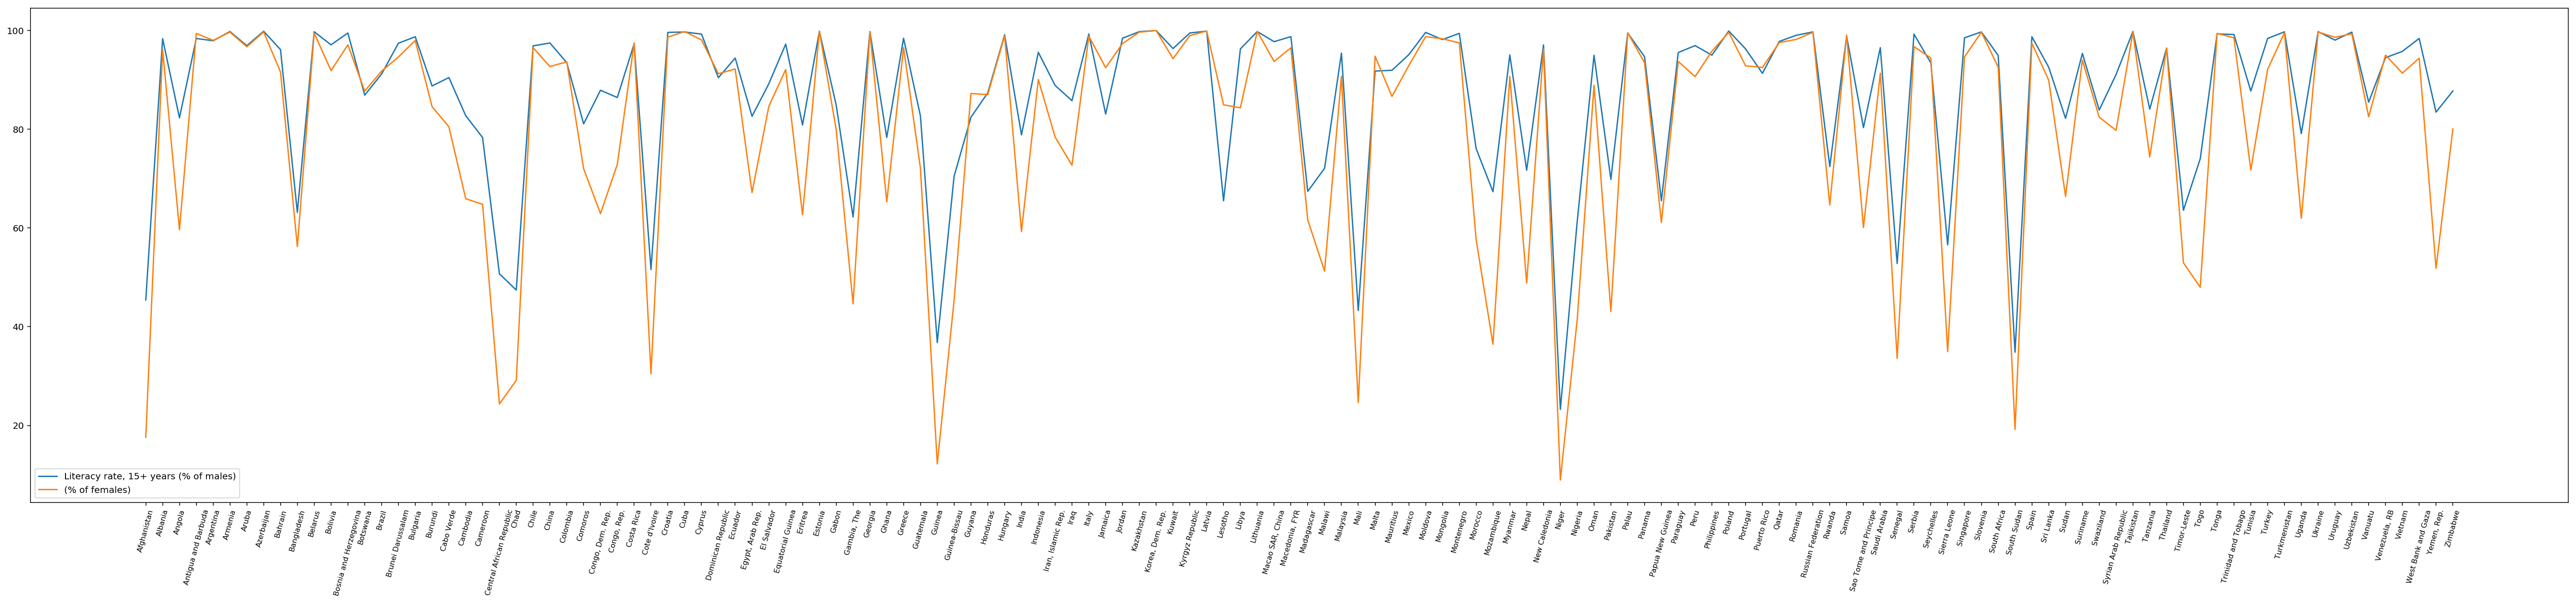

In [19]:
# Initializing the pyplot
fig1 = plt.figure()

# Rotating the x-tick (country) labels so that they appear separate from one another
plt.xticks(rotation=75)

# Plotting a line graph of our data, with country names on the x-axis and lit. rate values on the y-axis
plt.plot(recent_m_lit_data['CountryName'], recent_m_lit_data['Value'], label='Literacy rate, 15+ years (% of males)')
plt.plot(recent_f_lit_data['CountryName'], recent_f_lit_data['Value'], label='(% of females)')

# Make the legend appear on the plot
plt.legend()

# Displaying the plot, then closing it
display(fig1)
plt.close(fig1)

It is difficult to match countries to their values on the line here by glancing at it, and while we can see the difference between male and female literacy rates here, just how different they are is a little unclear. Line plots are more useful in showing transition between points, but since our data is categorical by country where the order of countries doesn't matter, a line plot is less useful.

### Using a bar plot instead of a line plot
A bar plot proves a much better visualization of this data:

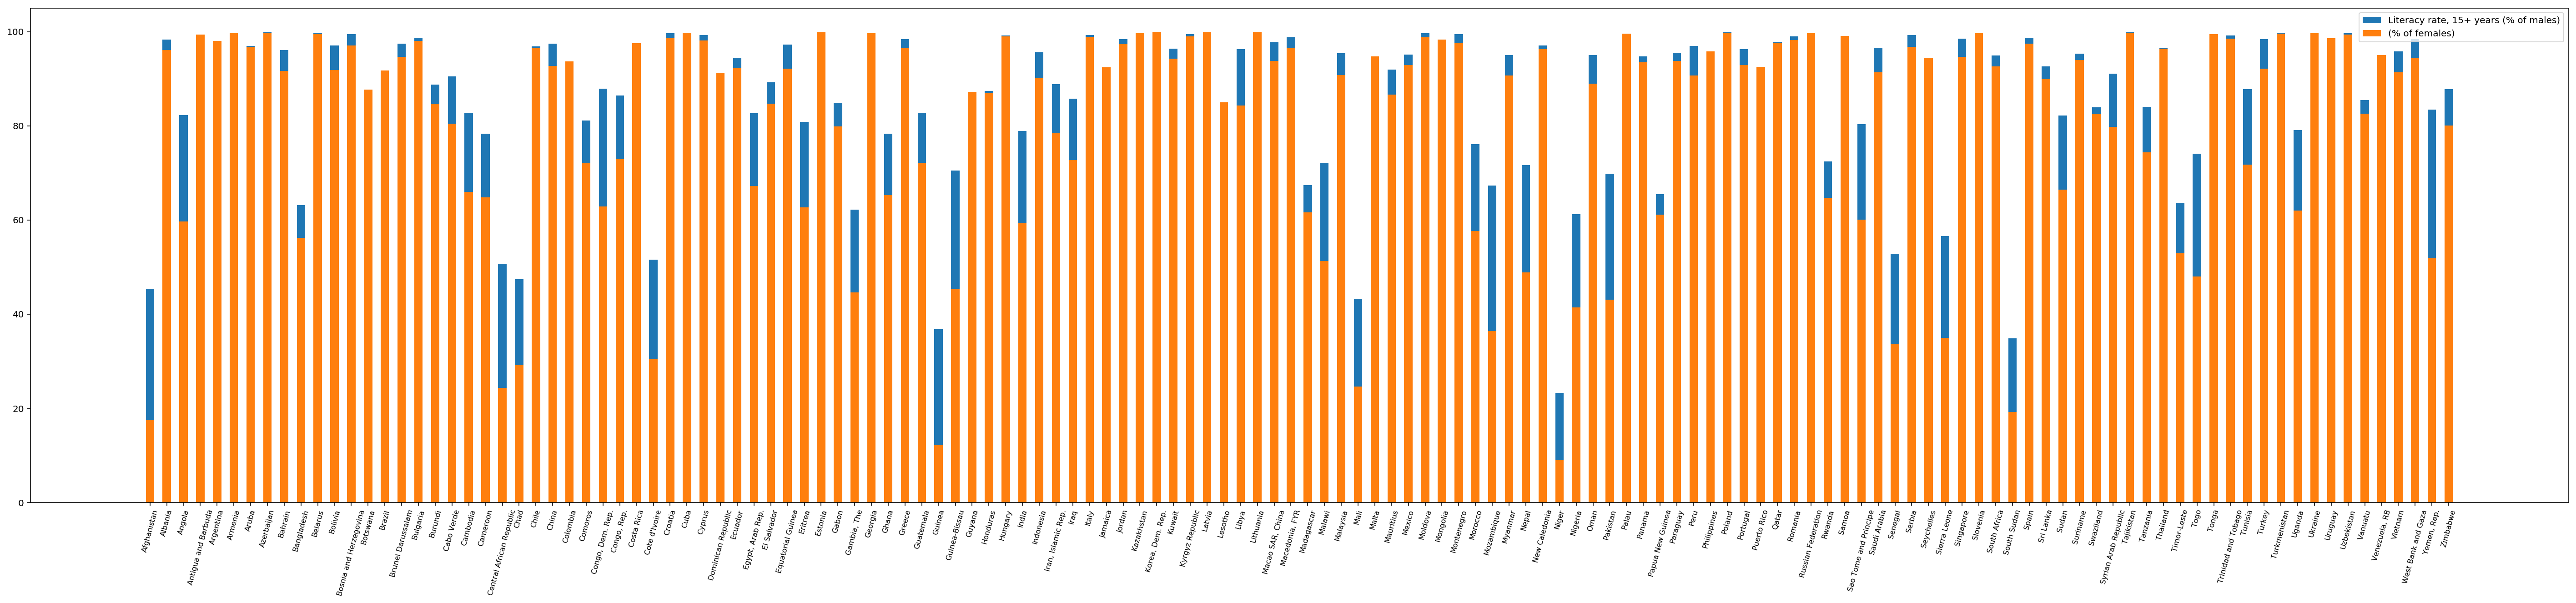

In [20]:
# Initializing the pyplot
fig2 = plt.figure()

# Rotating the x-tick (country) labels so that they appear separate from one another
plt.xticks(rotation=75)

# Plotting a line graph of our data, with country names on the x-axis and lit. rate values on the y-axis
plt.bar(recent_m_lit_data['CountryName'], recent_m_lit_data['Value'], width=0.5, label='Literacy rate, 15+ years (% of males)')
plt.bar(recent_f_lit_data['CountryName'], recent_f_lit_data['Value'], width=0.5, label='(% of females)')

# Make the legend appear on the plot
plt.legend()

display(fig2)
plt.close(fig2)

The graph above nicely allows one to match countries to their literacy rate values visually, and even shows the difference between male and female adult literacy rates for each country nicely (larger blue areas indicate greater disparity between males and females).

But for some of the countries, the % of literate adult females is higher than males, and in this graph, we can't see the male literacy rates for those countries--it's covered up!

### Placing the bars side-by-side
We'll need to get more creative to fix this. Pyplots let you shift additional bars to the right and left with addition or subtraction along the x-axis, but then we'll need to plot integers, rather than country names themselves, on the x-axis and simply label them as countries.

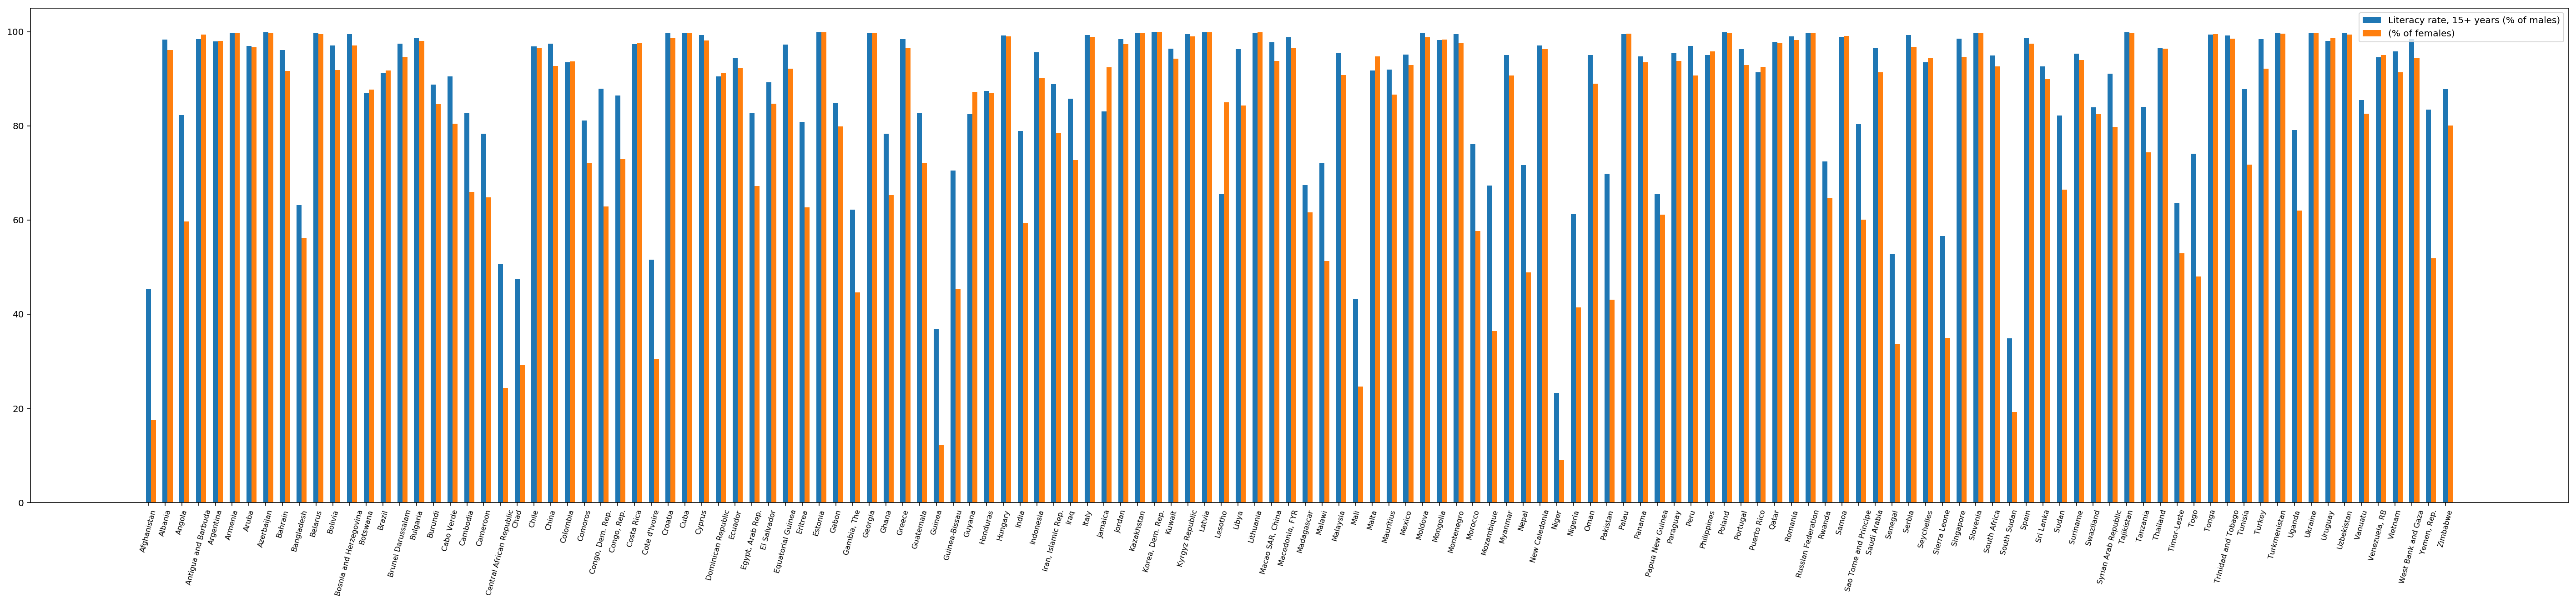

In [21]:
# Creating an array of values spaning the length of the data for our new x-axis
ind = np.arange(0,len(recent_m_lit_data),1)


fig3 = plt.figure()

# Adjusting our x-tick settings so that the x-axis contains our integer array but displays our country names
plt.xticks(ind, recent_m_lit_data['CountryName'], rotation=75)

# Passing in the integer array ind as our x-values
plt.bar(ind, recent_m_lit_data['Value'], width=0.3, label='Literacy rate, 15+ years (% of males)')

# Shifting our female x-axis to the right by the width we set for the bars
plt.bar(ind+0.3, recent_f_lit_data['Value'], width=0.3, label='(% of females)')
plt.legend()

display(fig3)
plt.close(fig3)

Now we have placed our bar plots side-by-side, but there's still a problem with how we've been plotting our data: we are plotting data from two different dataframes. 

In some ways, it is logical to keep our male and female data separate for comparison, but keeping them consistent with eachother is more difficult when they are stored in seperate dataframes. 

For instance, the plot above solves the issue of not being able to see every datapoint, but looks more chaotic as a result. A way to better present the data would be to sort it by value; but sorting will mess up the plots, since the male and female data currently sit in different dataframes and might have a different order of countries by increasing/decreasing value, and we need to keep the order of countries the same between both datasets.

### Merging the male and female datasets
To fix this, we'll merge the values from each dataset into one dataframe, using the country codes (a unique identifier) as the key that will bind the male and female data to one another.

We'll keep the merged set simple and just take the 'CountryName' and 'Value' fields from each, since that's all we're plotting:

In [22]:
# Merging to dataframe copies of two of the columns from the male and female datasets
merged_lit_data_toplot = pd.merge(recent_m_lit_data[['CountryName','Value']], recent_f_lit_data[['CountryName','Value']], on='CountryName')

# Renaming the merged dataframe's columns to avoid confusion
merged_lit_data_toplot.columns = ['Country', 'Value_m','Value_f']
merged_lit_data_toplot.head()

,Country,Value_m,Value_f
0,Afghanistan,45.417099,17.612062
1,Albania,98.352608,96.136070
2,Angola,82.323273,59.671429
3,Antigua and Barbuda,98.400002,99.419998
4,Argentina,97.932983,98.011864


### Sorting the values
Now, we can safely sort the merged dataset--let's sort by female literacy rate ascending:

In [23]:
# Sorting the merged data by the female values, ascending
merged_lit_data_toplot= merged_lit_data_toplot.sort_values(by='Value_f')
merged_lit_data_toplot.head()

,Country,Value_m,Value_f
84,Niger,23.247473,8.939735
47,Guinea,36.789780,12.191971
0,Afghanistan,45.417099,17.612062
111,South Sudan,34.836933,19.186375
21,Central African Republic,50.712711,24.355490


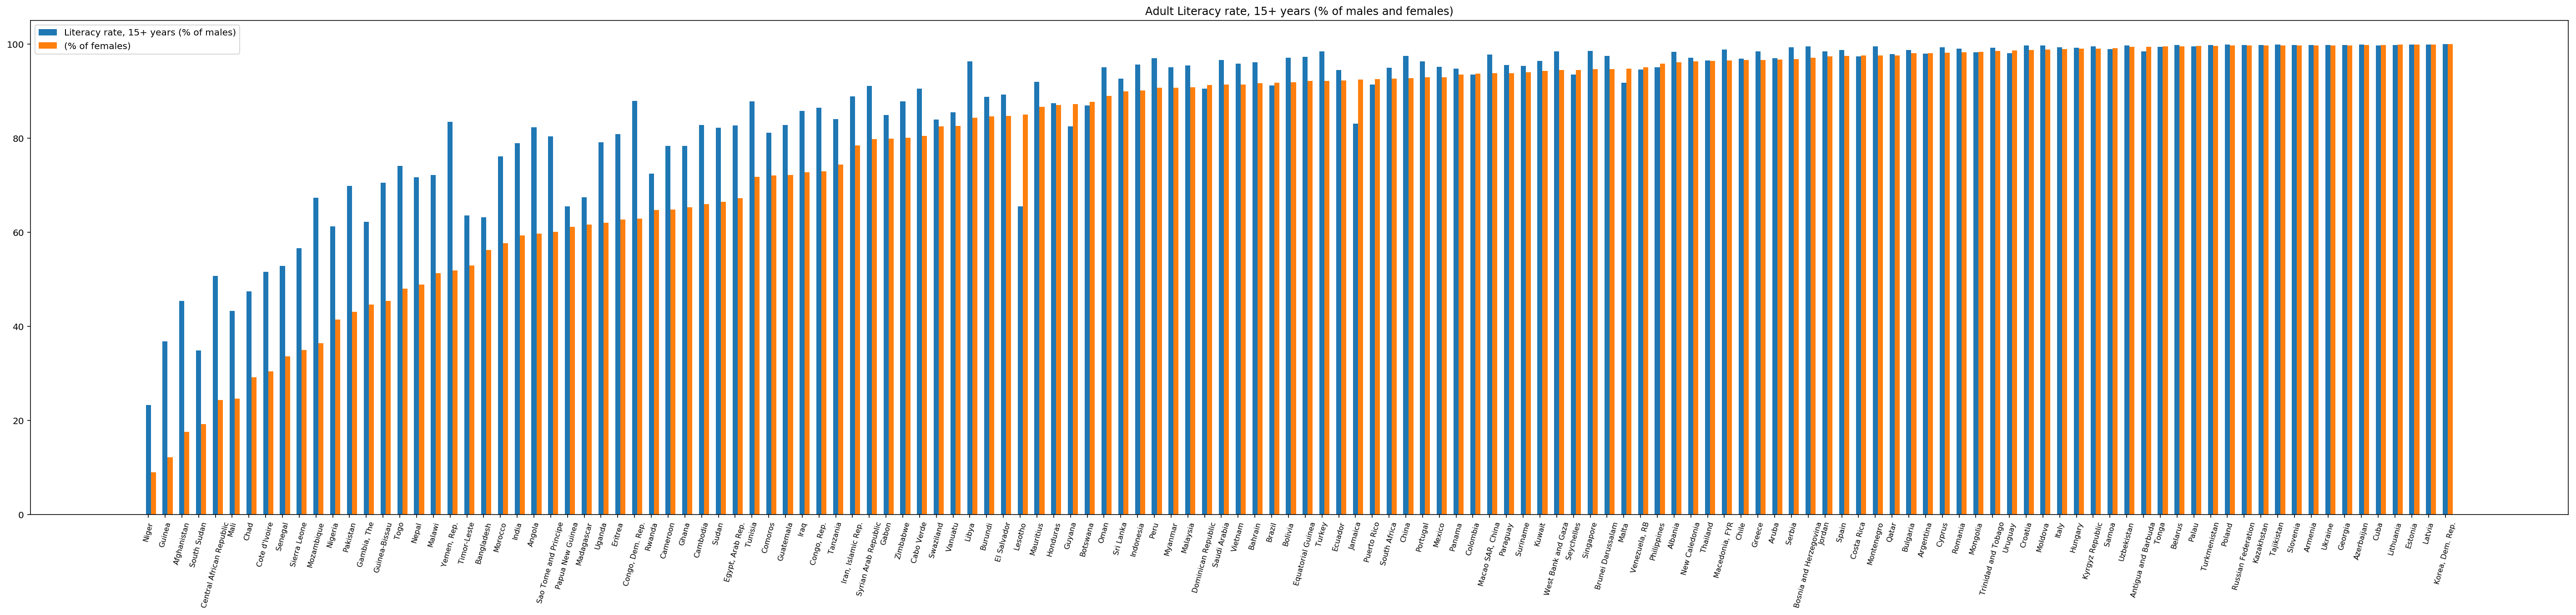

In [24]:
fig4 = plt.figure()

plt.xticks(ind, merged_lit_data_toplot['Country'], rotation=75)

# Giving the plot a title
plt.title('Adult Literacy rate, 15+ years (% of males and females)')

plt.bar(ind, merged_lit_data_toplot['Value_m'], width=0.3, label='Literacy rate, 15+ years (% of males)')
plt.bar(ind+0.3, merged_lit_data_toplot['Value_f'], width=0.3, label='(% of females)')
plt.legend()

# Saving the figure to a .png file with a high resolution (dpi)
plt.savefig('plots/adult_literacy_rate_bar1.png', dpi=200)

# 
display(fig4)
plt.close(fig4)

The graph above is far more sighlty than the previous graph, and all of the male and female values are visible and pretty easily comparable.

If interested in only the disparity between the male and female literacy rates by country, a better way to visualize the data would be to subtract the female values for each country from the male values in a separate column, and plot only that column:

In [25]:
# Creating an array of the differences between male and female literacy rate values to be added
difference_data_toadd = merged_lit_data_toplot['Value_m'] - merged_lit_data_toplot['Value_f']

#Inserting the above array into a column at the end of the merged dataframe
merged_lit_data_toplot.insert(len(merged_lit_data_toplot.columns), 'M-F Value', difference_data_toadd)

# Storing a copy of the merged data frame to plot, sorted by the new difference value descending
difference_data_toplot = merged_lit_data_toplot[:].sort_values(by='M-F Value',ascending=False)

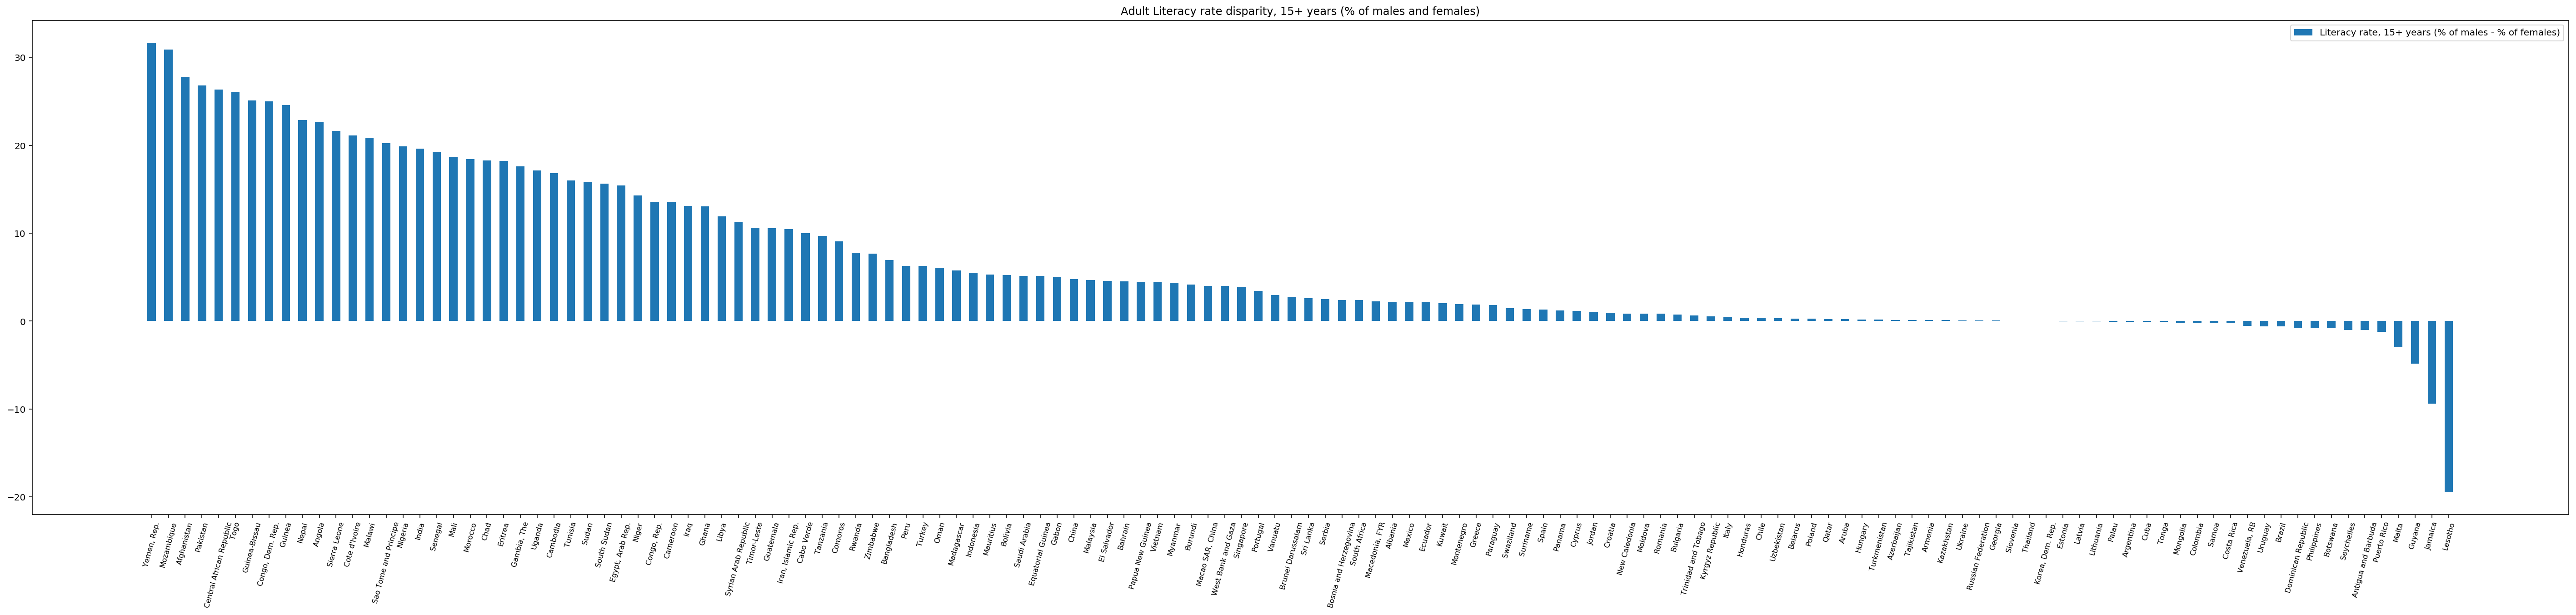

In [26]:
fig5 = plt.figure()

plt.xticks(rotation=75)

plt.title('Adult Literacy rate disparity, 15+ years (% of males and females)')

plt.bar(difference_data_toplot['Country'], difference_data_toplot['M-F Value'], width=0.5, label='Literacy rate, 15+ years (% of males - % of females)')
plt.legend()

plt.savefig('plots/adult_literacy_rate_bar2.png', dpi=200)

display(fig5)
plt.close(fig5)

Positive values in the above graph indicate where males have a greater adult literacy rate than females, while negative values indicate where females have a higher literacy rating than males.

# Part 3 - Performing simple linear regression on indicator data

We've visualizaed a couple of different indicators - fertility rate and male and female adult literacy rates by country. What if we want to see how these different indicators are related to eachother?

Treating them as seperate variables, we can perform linear regression with ordinary least squares to see how the two indicators are correlated--specifically, to what extent might literacy rate for males or females predict the fertility rate in a country.

## Data prep
Once again, we'll set up the data we want to analyze; and this time, since we just want to examine the relationship between two indicators, we don't need to filter the data by year as we did before. How well our model uses one variable to predict the other depends on the amount of datapoints we have, so we'll want to include as many as possible.

Let's take data for fertility rate, and male and female adult literacy rate for all years:

In [27]:
# Using the filter created in part 1 to extract fertility data for all years
fertility_data = data[filter1]

# Adult iteracy rate (all years) dataframes created in part 2:
# m_literacy_data, f_literacy_data

# Checking the length of each set:
print('fertility_data, # of records: ', len(fertility_data))
print('m_literacy_data, # of records: ', len(m_literacy_data))
print('f_literacy_data, # of records: ', len(f_literacy_data))

fertility_data, # of records:  12266
m_literacy_data, # of records:  734
f_literacy_data, # of records:  734


There are far more recordings of fertility data than of adult literacy data, so with adult literacy data as our limiting factor, we'll need to take just the records from the fertility rate dataset that match the years and countries of the literacy sets.

### Adding a column to each dataset
To do this, we can add a column to each dataframe that stores a concatenation the CountryCode and Year for each record, and then filter out all of the records from the fertility dataset that do not match those CountryCode+Year values from the literacy datasets.

In [28]:
# Creating the CountryCode+Year columns to add to each dataframe
fert_data_toadd, m_lit_data_toadd, f_lit_data_toadd = fertility_data['CountryCode'] + fertility_data['Year'].map(str), m_literacy_data['CountryCode'] + m_literacy_data['Year'].map(str), f_literacy_data['CountryCode'] + f_literacy_data['Year'].map(str)

# Adding the new columns to the end of each dataframe
fertility_data.insert(len(fertility_data.columns),'Country+Year',fert_data_toadd)
m_literacy_data.insert(len(m_literacy_data.columns),'Country+Year',m_lit_data_toadd)
f_literacy_data.insert(len(f_literacy_data.columns),'Country+Year',f_lit_data_toadd)

fertility_data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value,Country+Year
14,Arab World,ARB,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,1960,6.924027,ARB1960
93,Caribbean small states,CSS,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,1960,5.520103,CSS1960
182,Central Europe and the Baltics,CEB,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,1960,2.498618,CEB1960
259,East Asia & Pacific (all income levels),EAS,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,1960,5.396794,EAS1960
372,East Asia & Pacific (developing only),EAP,"Fertility rate, total (births per woman)",SP.DYN.TFRT.IN,1960,5.826618,EAP1960


In [29]:
# Creating filters for each dataset to ensure their Country+Year values match
fert_filter = fertility_data['Country+Year'].isin(m_literacy_data['Country+Year'])
m_lit_filter, f_lit_filter = m_literacy_data['Country+Year'].isin(fertility_data['Country+Year']), f_literacy_data['Country+Year'].isin(fertility_data['Country+Year'])

# Applying the filters to each dataset
fert_data_filtered = fertility_data[fert_filter] # Apply this filter first 
m_lit_data_filtered, f_lit_data_filtered = m_literacy_data[m_lit_filter], f_literacy_data[f_lit_filter]

# Checking the counts to make sure they match
print('fert_data_filtered, # of records: ', len(fert_data_filtered))
print('m_lit_data_filtered, # of records: ', len(m_lit_data_filtered))
print('f_lit_data_filtered, # of records: ', len(f_lit_data_filtered))

fert_data_filtered, # of records:  722
m_lit_data_filtered, # of records:  722
f_lit_data_filtered, # of records:  722


### Merging the datasets
Now that the dataframes are properly filtered, we can merge them into one dataframe using Country+Year as the key.

In [30]:
# Merging the fertility rate dataset with the male literacy rate dataset
merged_data0 = pd.merge(fert_data_filtered[['Country+Year', 'Value']], m_lit_data_filtered[['Country+Year', 'Value']], on='Country+Year')

# Adding the female literacy rate data to the merged dataset
merged_data1 = pd.merge(merged_data0, f_lit_data_filtered[['Country+Year', 'Value']], on='Country+Year')

# Renaming the columns to avoid confusion
merged_data1.columns = ['Country+Year', 'fert_rate', 'm_lit_rate', 'f_lit_rate']

merged_data1.head()

,Country+Year,fert_rate,m_lit_rate,f_lit_rate
0,GRD1970,4.604,96.00000,96.00000
1,BFA1975,6.859,14.52849,3.18277
2,CAF1975,5.950,29.59292,8.39958
3,KWT1975,6.427,68.02863,48.01521
4,TUR1975,5.008,77.50394,45.09892


## Plotting the data with plt.scatter()
The data is now ready to plot; and this time, we'll use a scatter plot to visualize the relationship between fertility rate and female adult literacy rate.

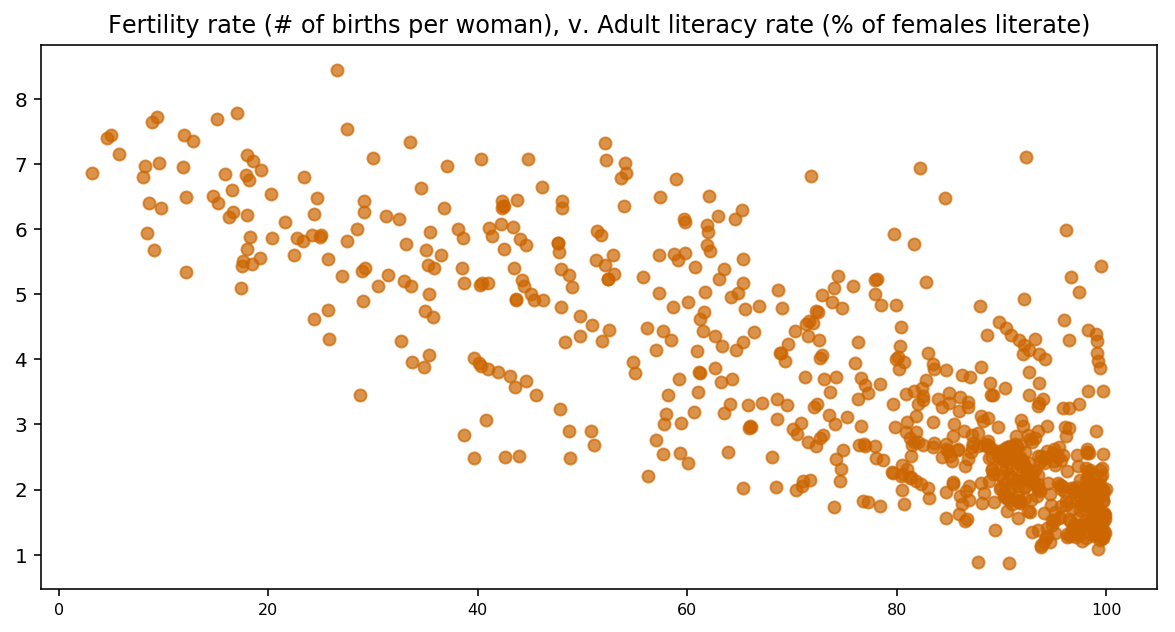

In [31]:
# Adjusting the size of the figure
rcParams['figure.figsize'] = 10,5

fig6 = plt.figure()

plt.title('Fertility rate (# of births per woman), v. Adult literacy rate (% of females literate)')
plt.scatter(merged_data1['f_lit_rate'],merged_data1['fert_rate'], alpha=0.7, color=(0.8, 0.4, 0.0))

display(fig6)
plt.close(fig6)

Now let's plot fertility rate v. adult male literacy rate:

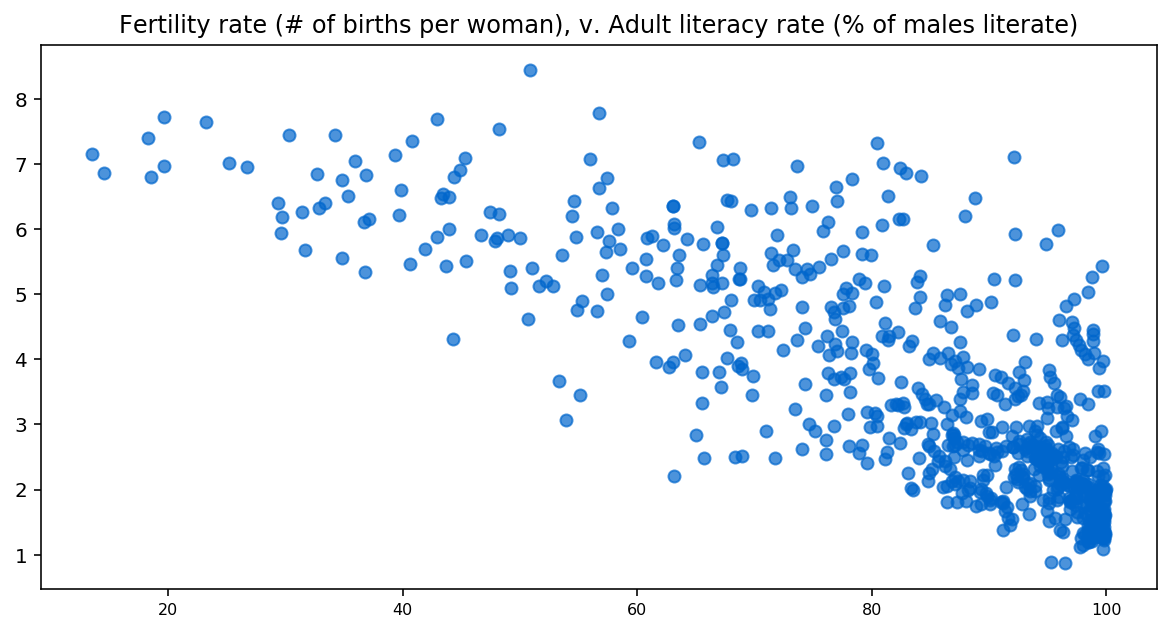

In [32]:
fig7 = plt.figure()

plt.title('Fertility rate (# of births per woman), v. Adult literacy rate (% of males literate)')
plt.scatter(merged_data1['m_lit_rate'],merged_data1['fert_rate'], alpha=0.7, color=(0.0, 0.4, 0.8))

display(fig7)
plt.close(fig7)

## Performing linear regression on the data, using the results to plot a line of best fit
Now we want to analyze our data statistically. For this, we'll import two more python modules--<a href='https://patsy.readthedocs.io/en/latest/'>patsy</a> and <a href='https://www.statsmodels.org/dev/index.html'>statsmodels</a>.

In [33]:
import patsy
import statsmodels.api as sm

In short, patsy provides a speacial way to organize our data in a way that statsmodels.api can process in order to give us rather comprehensive statistical analyses of our data.

### Creating an ordinary least squares model for the data
We'll use patsy.dmatrices() to give us our x and y values to pass into our ordinary least squares model in statsmodels.api:

In [34]:
# Creating a patsy design matrix for our merged data
y_vals1, x_vals1 = patsy.dmatrices('fert_rate ~ f_lit_rate', merged_data1)

# Generating an ordinary least squares model for our predictor (x) and outcome (y) values
model1 = sm.OLS(y_vals1, x_vals1)

# Calling .fit() the model to obtain results of the analysis
results1 = model1.fit()

The statsmodels.api OLS model provides a lot of information, though for our regression line to plot, we only need the y-intercept and slope for the regression line.

Those values are stored under the 'params' attribute of our results:

In [35]:
b1, m1 = results1.params[0], results1.params[1]
print('y-intercept for regression line: ', b1)
print('slope of regression line: ', m1)

y-intercept for regression line:  7.432713003963028
slope of regression line:  -0.05351911068851221


### Plotting the regression line
Now we have to create our regression line. The x-values can just be an array of integer values that span the data, and the y-values can be set to the result of multiplying those x-values by the slope, added to the y-intercept (essentially a line of y = mx + b form).

In [36]:
# Forming our regression line x and y values
regression_x1 = np.arange(merged_data1['f_lit_rate'].min(), merged_data1['f_lit_rate'].max())
regression_y1 = m1 * regression_x1 + b1

Lastly, we plot the regression line over our scatter plot of from before:

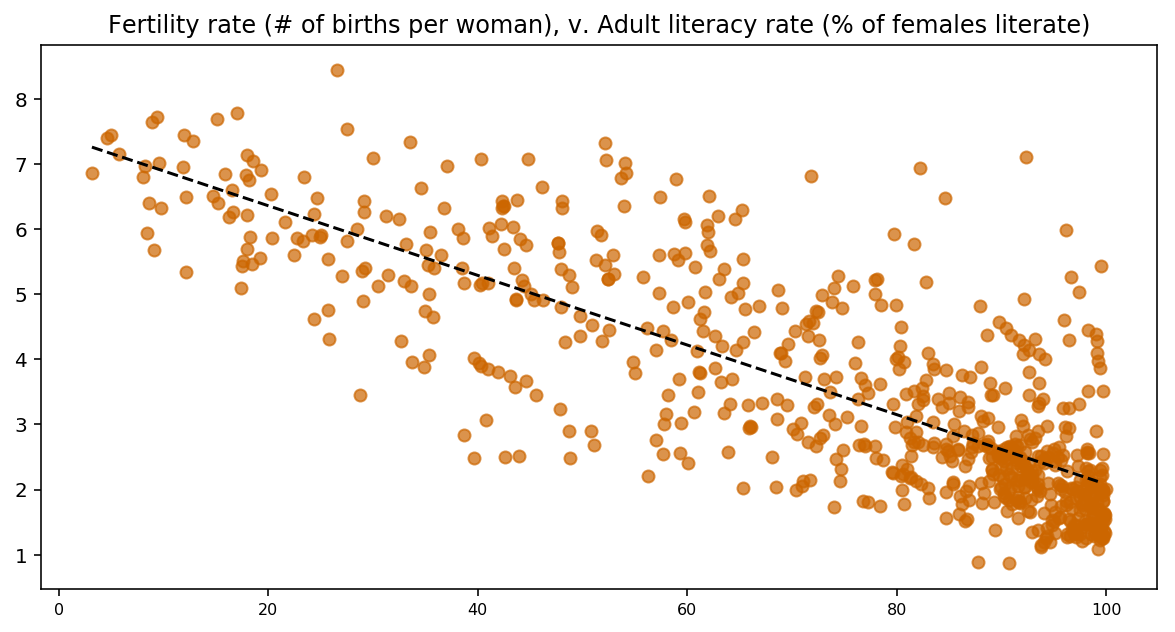

In [37]:
fig8 = plt.figure()

plt.title('Fertility rate (# of births per woman), v. Adult literacy rate (% of females literate)')
plt.scatter(merged_data1['f_lit_rate'],merged_data1['fert_rate'], alpha=0.7, color=(0.8, 0.4, 0.0))

# Plotting the line of best fit, and labeling it as its equation in y = mx + b form
plt.plot(regression_x1, regression_y1, '--k', label='y = ' +str(round(m1, 3))+'x + '+str(round(b1, 3)))

plt.savefig('plots/fert_rate_v_lit_rate1.png', dpi=200)

display(fig8)
plt.close(fig8)

We can print a sumamry of our results from the OLS model we created to produce this line for more a more numerical report of our analyses:

In [38]:
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:              fert_rate   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1301.
Date:                Mon, 21 Jan 2019   Prob (F-statistic):          1.52e-163
Time:                        19:41:58   Log-Likelihood:                -1035.8
No. Observations:                 722   AIC:                             2076.
Df Residuals:                     720   BIC:                             2085.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4327      0.115     64.357      0.0

Now, let's do the same for fertility rate v. male adult literacy rate:

In [39]:
# Creating a patsy design matrix for our maerged data
y_vals2, x_vals2 = patsy.dmatrices('fert_rate ~ m_lit_rate', merged_data1)

# Generating an ordinary least squares model for our predictor (x) and outcome (y) values
model2 = sm.OLS(y_vals2, x_vals2)

# Calling .fit() the model to obtain results of the analysis
results2 = model2.fit()

b2, m2 = results2.params[0], results2.params[1]
print('y-intercept for regression line: ', b2)
print('slope of regression line: ', m2)

# Forming our regression line x and y values
regression_x2 = np.arange(merged_data1['m_lit_rate'].min(), merged_data1['m_lit_rate'].max())
regression_y2 = m2 * regression_x2 + b2

y-intercept for regression line:  9.5924580783778
slope of regression line:  -0.07350330046323392


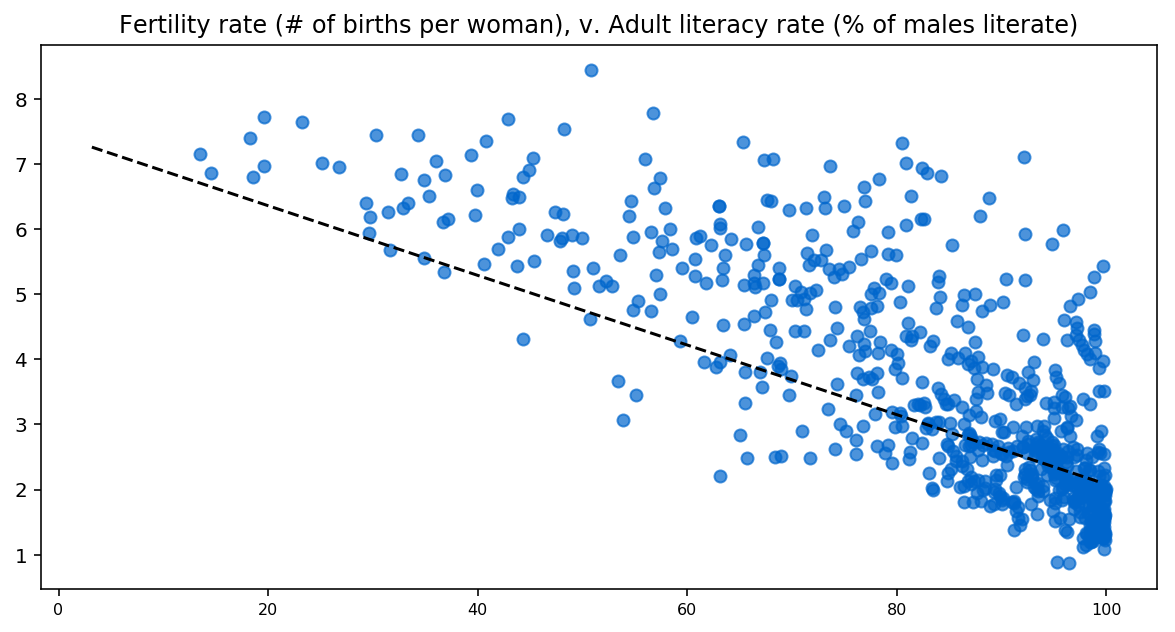

In [40]:
fig8 = plt.figure()

plt.title('Fertility rate (# of births per woman), v. Adult literacy rate (% of males literate)')
plt.scatter(merged_data1['m_lit_rate'],merged_data1['fert_rate'], alpha=0.7, color=(0.0, 0.4, 0.8))

plt.plot(regression_x1, regression_y1, '--k', label='y = ' +str(round(m1, 3))+'x + '+str(round(b1, 3)))

plt.savefig('plots/fert_rate_v_lit_rate2.png', dpi=200)

display(fig8)
plt.close(fig8)

In [41]:
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:              fert_rate   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     1107.
Date:                Mon, 21 Jan 2019   Prob (F-statistic):          1.07e-147
Time:                        19:41:59   Log-Likelihood:                -1072.4
No. Observations:                 722   AIC:                             2149.
Df Residuals:                     720   BIC:                             2158.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5925      0.188     51.154      0.0

## Analyzing the results
From the top section in the female results, we see that the adjusted r-squared value for this model is **0.643**, and in the male results, **0.605**. That means at least 60% of the variation in both plots is explained by our linear model, and since both regression lines have a negative slope, we can assume there is some negative relationship between fertility rate and literacy rate in both a country's males and females--in other words, as literacy rate goes up, fertility rate goes down.

A potential issue with this conclusion is that our data could be skewed a bit, so one can't rely solely on the model to make predictions about fertility rate on adult literacy rate alone. But given the male and female literacy rate data sample from the same countries and years, we can at least say, based on the r-squared values from each test, that there seems to be a greater correlation between births per woman and the % of literate females in a country than % of literate males in that country.
